## iZettle Data Science Assignment - CPV ##

Thanks for taking time to complete the iZettle data science assignment.
<br>
This is to give you an idea about the challenges that we may face at iZettle. Also, it will help us understand how you would tackle them.
<br>
Feel free to scope the assignment as appropriate. Make sure to motivate what you did and why.

The goal is to estimate the Card Payment Volume (CPV) of each organization
during their first, second and third month after creation (i.e. the sum of the
amount of every transaction in each month). The prediction should be based
on the first 14 days of data after the organization was created.

You’ll find two CSV files attached with the following data:

data/organization_ids.csv:
- organization_id Unique identifier for each organization
- organization_created Date on which organization was onboarded

data/payment_ids.csv:
- organization_id Unique identifier for each organization
- card_payment_id Unique identifier for a payment that was completed
- timestamp Time of event
- currency_id Currency
- amount Amount of the transaction
- device_type The device connected to the card reader
- card_payment_entry_mode Payment technology
- payment_type Valid payment or invalid

### Imports ###

In [56]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Loading and Preparation ###

We'll load the 2 csv's, and merge them on the organization id.

In [83]:
payment_df = pd.read_csv('payment_ids.csv')

In [84]:
organization_df = pd.read_csv('organization_ids.csv')

In [85]:
master_df = pd.merge(payment_df, organization_df, on='organization_id')

<br>
<br>
Let's take a quick look at the categorical columns, and see how they're distributed.

In [5]:
master_df.columns

Index(['organization_id', 'timestamp', 'amount', 'currency_id',
       'card_payment_entry_mode', 'device_type', 'payment_type',
       'organization_created'],
      dtype='object')

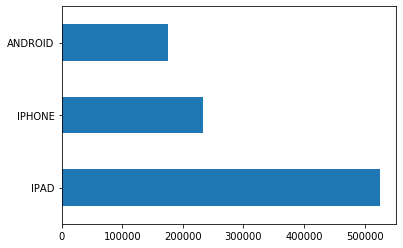

In [6]:
master_df['device_type'].value_counts().plot(kind='barh')

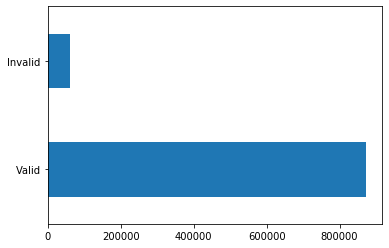

In [7]:
master_df['payment_type'].value_counts().plot(kind='barh')

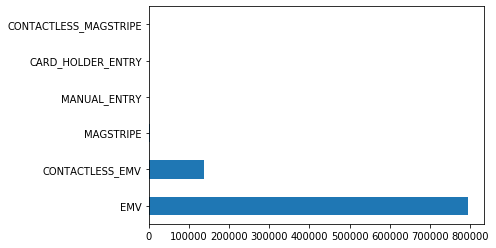

In [8]:
master_df['card_payment_entry_mode'].value_counts().plot(kind='barh')

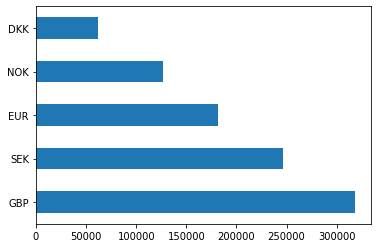

In [9]:
master_df['currency_id'].value_counts().plot(kind='barh')

<br>
<br>
Now we need to convert the time columns to timestamps, as they are originally loaded as strings.

In [86]:
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'], infer_datetime_format=True, errors='coerce')
master_df['organization_created'] = pd.to_datetime(master_df['organization_created'], infer_datetime_format=True, errors='coerce')

## Feature Engineering ##

We're going to need organizational age, so we calculate that in days.

In [87]:
master_df['organization_age'] = (master_df['timestamp'] - master_df['organization_created']).dt.days

<br>
<br>
The column with the payment amount contains values in multiple currencies. In order to make meaningful predictions, we need to make the amounts uniform. We're going to convert all the amounts to Euros. First, we create variables for the different exchange rates. Then we create a list for EUR amounts which will be used for conversion. Then we convert the currencies, and add the column to the dataframe.

In [88]:
GBP = 1.14
NOK = 0.1
SEK = 0.1
DKK = 0.13

In [89]:
amount_eur = []

In [90]:
for index, row in master_df.iterrows():
    if master_df['currency_id'][index] == 'GBP':
        amount_eur.append(master_df['amount'][index] * GBP)
    elif master_df['currency_id'][index] == 'NOK':
        amount_eur.append(master_df['amount'][index] * NOK)
    elif master_df['currency_id'][index] == 'SEK':
        amount_eur.append(master_df['amount'][index] * SEK)
    elif master_df['currency_id'][index] == 'DKK':
        amount_eur.append(master_df['amount'][index] * DKK)
    else:
        amount_eur.append(master_df['amount'][index])

In [91]:
master_df['amount_eur'] = amount_eur

<br>
<br>
As we're predicting sums, we'll create features based on these sums. We have to be careful here about potential data leakage here. We'll create a feature based on the sum in the first 14 days, a feature for the rest of the first month, a feature for the second month, and a feature for the third month.

In [58]:
master_df['month'] = master_df['organization_age'] // 30

In [75]:
monthly_cpv_df = pd.DataFrame(master_df.groupby(['organization_id', 'month'])['amount_eur'].sum()).reset_index().pivot(index='organization_id', 
                                                                                                      columns='month', 
                                                                                                      values='amount_eur').fillna(0)

In [81]:
monthly_cpv_df = monthly_cpv_df.iloc[:,0:3]

In [95]:
fourteen_days_df = master_df[master_df['organization_age'] <= 14]

In [141]:
currency_df = fourteen_days_df.pivot_table(index='organization_id', columns='currency_id', values='amount_eur', aggfunc=np.sum, fill_value=0)
card_payment_df = fourteen_days_df.pivot_table(index='organization_id', columns='card_payment_entry_mode', values='amount_eur', aggfunc=np.sum, fill_value=0)
device_df = fourteen_days_df.pivot_table(index='organization_id', columns='device_type', values='amount_eur', aggfunc=np.sum, fill_value=0)
payment_df = fourteen_days_df.pivot_table(index='organization_id', columns='payment_type', values='amount_eur', aggfunc=np.sum, fill_value=0)

In [142]:
counts_df = pd.concat([currency_df,
                       card_payment_df,
                       device_df,
                       payment_df], axis=1)

In [143]:
counts_df.columns = ['amt_eur_' + str(col) for col in counts_df.columns]

In [144]:
features_df

,amt_eur_DKK,amt_eur_EUR,amt_eur_GBP,amt_eur_NOK,amt_eur_SEK,amt_eur_CARD_HOLDER_ENTRY,amt_eur_CONTACTLESS_EMV,amt_eur_CONTACTLESS_MAGSTRIPE,amt_eur_EMV,amt_eur_MAGSTRIPE,amt_eur_MANUAL_ENTRY,amt_eur_ANDROID,amt_eur_IPAD,amt_eur_IPHONE,amt_eur_Invalid,amt_eur_Valid
organization_id,,,,,,,,,,,,,,,,
000-4e6abe9c388d,0.0,10.0,0.000,0.0,0.0,0.00,0.0,0.0,10.000,0.0,0.0,10.000,0.0,0.00,0.00,10.000
001-3b5eba101430,0.0,0.0,60.648,0.0,0.0,0.00,0.0,0.0,60.648,0.0,0.0,60.648,0.0,0.00,0.00,60.648
001-3d39160884ba,0.0,0.0,2.280,0.0,0.0,1.14,0.0,0.0,1.140,0.0,0.0,0.000,0.0,2.28,0.00,2.280
001-3e822db41946,0.0,892.7,0.000,0.0,0.0,0.00,18.3,0.0,870.400,4.0,0.0,544.700,0.0,348.00,10.00,882.700
001-7162bc3e0996,0.0,0.0,0.000,744.0,0.0,0.00,0.0,0.0,744.000,0.0,0.0,744.000,0.0,0.00,0.00,744.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb-5f5d36b98e83,0.0,0.0,76.380,0.0,0.0,0.00,0.0,0.0,76.380,0.0,0.0,76.380,0.0,0.00,50.16,26.220
ffc-0d4b0c9be14b,0.0,257.0,0.000,0.0,0.0,0.00,50.0,0.0,207.000,0.0,0.0,0.000,0.0,257.00,0.00,257.000
ffe-f72cc7a435de,0.0,0.0,0.000,300.0,0.0,0.00,0.0,0.0,300.000,0.0,0.0,300.000,0.0,0.00,0.00,300.000


In [148]:
modeling_df = pd.merge(left=features_df, right=monthly_cpv_df, on='organization_id')

<br>
<br>
There are a number of categorical features in the dataset, which can be one-hot encoded. Let's do this now:

In [34]:
master_df.columns

Index(['organization_id', 'timestamp', 'amount', 'currency_id',
       'card_payment_entry_mode', 'device_type', 'payment_type',
       'organization_created', 'organization_age', 'amount_eur',
       'amt_to_14_days_sum', 'amt_15_to_30_days_sum', 'amt_61_to_90_days_sum',
       'amt_31_to_60_days_sum'],
      dtype='object')

In [35]:
# Currency
currency_dummies = pd.get_dummies(master_df['currency_id'], prefix='is_currency', prefix_sep='_', dummy_na=True, drop_first=False)

# Card Payment Entry Mode
card_payment_entry_mode_dummies = pd.get_dummies(master_df['card_payment_entry_mode'], prefix='is_card_payment_entry mode', prefix_sep='_', dummy_na=True, drop_first=False)

# Device Type
device_type_dummies = pd.get_dummies(master_df['device_type'], prefix='is_device_type', prefix_sep='_', dummy_na=True, drop_first=False)

# Payment Type
payment_type_dummies = pd.get_dummies(master_df['payment_type'], prefix='is_payment_type', prefix_sep='_', dummy_na=True, drop_first=False)

<br>
<br>
Now we create a master dataframe for modeling:

In [38]:
modeling_df = pd.concat([master_df[['organization_age',
                                     'amount_eur']],
                                      currency_dummies,
                                      card_payment_entry_mode_dummies,
                                      device_type_dummies,
                                      payment_type_dummies],
                                      axis=1
                                     )

<br>
<br>

## Modeling ##

The first thing we need to do is split our dataset into training and testing. As we're instucted to use the first 14 days for training, we'll make the split as such:

In [43]:
train_df = modeling_df[modeling_df['organization_age'] <= 14]
test_df = modeling_df[modeling_df['organization_age'] > 14]

<br>
<br>
Now we split these into features and responses:

In [45]:
y_train = train_df['amount_eur']
y_test = test_df['amount_eur']

X_train = train_df.drop(['amount_eur', 'organization_age'], axis=1)
X_test = test_df.drop(['amount_eur', 'organization_age'], axis=1)

<br>
<br>
We're going to use the Random Forest algorithm, as it has excellent performance out-of-the-box, rarely overfits, and does automated feature selection. One thing we have to keep in mind is to set the seed for the random number generator, in order to increase reproducibility:

In [50]:
rf_model = RandomForestRegressor(random_state=176).fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

<br>
<br>
Let's calculate the basic regression accuracy metrics:

In [51]:
# Mean Absolute Deviation
mean_absolute_error(y_test, rf_predictions)

28.690864972009262

In [52]:
# Root Mean Squared Error
np.sqrt(mean_squared_error(y_test, rf_predictions))

108.1100461007641

<br>
<br>
Let's take a look at the feature importances of our model:

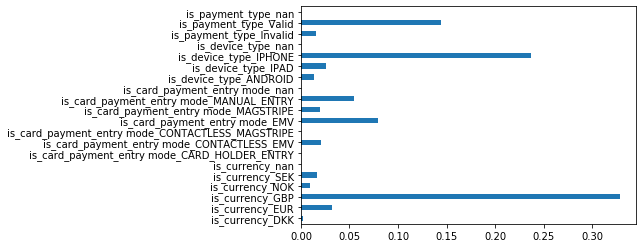

In [55]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X_test.columns)
feat_importances.plot(kind='barh')

We can see that the GBP currency, orders made through iPhones, and Valid payments contribute the most to the accuracy.

<br>
<br>

## Saving the Model ##

In order to re-use our model in a RESTful API service, we need to save it to disk. We could use either joblib or pickle. Here we go with pickle.

In [ ]:
pickle.dump(smote_rf, open('rf_model.pickle', 'wb'))